In [1]:
# Dec 2 2020
# Big Data Project 
# The decision tree

In [2]:
import csv 
import numpy as np
from collections import defaultdict
import random
import networkx as nx
from matplotlib import pyplot as plt

References: 

https://networkx.org/documentation/stable/tutorial.html

https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

# Data processing

In [3]:
filename = "decision_tree_cps3_reshape.csv"

data = [] 
  
# opening the CSV file 
with open(filename, mode ='r') as file:     
         
       # reading the CSV file 
       csvFile = csv.reader(file) 
  
       # displaying the contents of the CSV file 
       for line in csvFile: 
            data.append(line)

In [4]:
# add BIRTH variable to data
# 0 if NCHILD doesn't increase
# 1 if NCHILD does increase 
# 9 if NCHILD not in universe 

data[0][45]=('BIRTH')
for i in range(len(data[1:])):
    person = data[i+1]
    if float(person[41])>float(person[21]):
            person.append('1') #birth
            #print(len(person))
    elif float(person[41])==float(person[21]):
            person.append('0') #no birth
    else:
            person.append('9') #error

In [5]:
# remove minors from data
# originally there were 47000 rows 
# after this there are 36770

def remove_minors(data):
    data2 = []
    data2.append(data[0])
    for row in data[1:]:
        if int(row[15])>17:
            data2.append(row)
    return data2

# Make reference variables

In [6]:
# make dict with {variable name : index of variable} 
# for general utility 
def make_varInd(data):
    varInd = defaultdict(int)
    for i in range(len(data[0])):
        varInd[data[0][i]] = i
    return varInd

In [7]:
# get initial list of data indices [1, 2, 3, ... ] from data matrix
# (it takes care of row 0)
def make_dataInd(data):
    dataInd = []
    for i in range(1, len(data)):
        dataInd.append(i)
    return dataInd

In [8]:
varInd = make_varInd(data)
dataInd = make_dataInd(data)

In [28]:
# make a dict with {variable name : variable buckets}
def make_varLevels(data):

    varLevels = defaultdict(list) 

    varLevels['YEAR'] = [['2018'], ['2019']]
    #varLevels['MONTH'] = []
    varLevels['REGION'] = [] #['11', '12', '21', '22', '31', '32', '33', '41', '42']
    varLevels['STATEFIP'] = []
    varLevels['METRO'] = [] #['0', '1', '2', '3', '4']
    varLevels['FAMINC'] = [] #['100', '210', '300', '430', '470', '500', '600', '710', '720', '730', '740', '820', '830', '841', '842', '843', '999']
    varLevels['SEX'] = [] #[['1'], ['2']]
    varLevels['EMPSTAT'] = [['1', '10', '12'], ['21', '22'], ['0', '32', '34', '36']]
    varLevels['RELATE'] = [] 
    varLevels['AGE'] = [
    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17'],
    ['18','19','20','21','22','23','24','25','26','27','28','29'],
    ['30','31','32','33','34','35','36','37','38','39'],
    ['40','41','42','43','44','45','46','47','48','49'],
    ['50','51','52','53','54','55','56','57','58','59'],
    ['60','61','62','63','64','65','66','67','68','69'],
    ['70','71','72','73','74','75','76','77','78','79'],
    ['80'],
    ['85']
    ]
    varLevels['RACE'] = []
    varLevels['MARST'] = [['1', '2', '3'], ['4', '5', '7'], ['6'], ['9']]
    varLevels['NCHILD'] = []#[['0'], ['7'], ['4'], ['9'], ['1'], ['3'], ['8'], ['6'], ['2'], ['5']]
    varLevels['POPSTAT'] = []
    varLevels['VETSTAT'] = []
    varLevels['YRIMMIG'] = []
    varLevels['WHYUNEMP'] = []
    varLevels['WKSTAT'] = [] # basically tells employment 
    varLevels['PROFCERT'] = []
    varLevels['EDUC'] = [['10'], ['20'], ['30'], ['40', '50', '60', '71'], ['73'], ['81'], ['91', '92'], ['111'], ['124'], ['125'], ['0', '1', '2', '999']]
    varLevels['SCHLCOLL'] = [] 
    varLevels['CITIZEN'] = []
    varLevels['HISPAN'] = [['0'], ['100', '500', '400', '300', '600', '612', '200', '611']]
    varLevels['OCC'] = []
    varLevels['IND'] = []
    #varLevels['BIRTH'] = []
    
    # this is the variable that leaves that dont' keep splitting, split on
    varLevels['DONE'] = [[]] 
    
    
    for key in varLevels.keys(): 
        # fill in empty varLevels 
        if key != 'DONE' and varLevels[key]==[]:
            # loop through data
            outSet = set()
            for row in data[1:]:
                outSet.add(row[varInd[key]])
            # fill list with unique output codes 
            buckets = []
            for num in outSet:
                buckets.append([num])
            varLevels[key] = buckets            
        
    return varLevels

In [29]:
# make a dict with {variable name : variable buckets} for goal variables 
# the first bucket is the one we're predicting 
def make_goalLevels(data):

    varLevels = defaultdict(list) 

    varLevels['YEAR'] = ['2018', '2019']
    varLevels['MONTH'] = []
    varLevels['METRO'] = ['0', '1', '2', '3', '4']
    varLevels['FAMINC'] = ['100', '210', '300', '430', '470', '500', '600', '710', '720', '730', '740', '820', '830', '841', '842', '843', '999']
    varLevels['SEX'] = ['1', '2']
    varLevels['EMPSTAT'] = [['1', '10', '12'], ['21', '22'], ['0', '32', '34', '36']]
    varLevels['EMPSTAT2'] = [['1', '10', '12'], ['21', '22'], ['0', '32', '34', '36']]
    varLevels['RELATE'] = [] 
    varLevels['AGE'] = [
    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17'],
    ['18','19','20','21','22','23','24','25','26','27','28','29'],
    ['30','31','32','33','34','35','36','37','38','39'],
    ['40','41','42','43','44','45','46','47','48','49'],
    ['50','51','52','53','54','55','56','57','58','59'],
    ['60','61','62','63','64','65','66','67','68','69'],
    ['70','71','72','73','74','75','76','77','78','79'],
    ['80'],
    ['85']
    ]
    varLevels['RACE'] = []
    varLevels['MARST'] = [['1', '2', '3'], ['4', '5', '7'], ['6']]
    varLevels['NCHILD'] = [['0'], ['7'], ['4'], ['9'], ['1'], ['3'], ['8'], ['6'], ['2'], ['5']]
    varLevels['POPSTAT'] = []
    varLevels['VETSTAT'] = []
    varLevels['YRIMMIG'] = []
    varLevels['WHYUNEMP'] = []
    varLevels['WKSTAT'] = []
    varLevels['PROFCERT'] = []
    varLevels['EDUC'] = [['10'], ['20'], ['30'], ['40', '50', '60', '71'], ['73'], ['81'], ['91', '92'], ['111'], ['124'], ['125'], ['0', '1', '2']]
    varLevels['SCHLCOLL'] = [] 
    varLevels['MARST2'] = [['1', '2', '3'], ['4', '5', '7'], ['6'], ['9']]
    varLevels['NCHILD2'] = []
    varLevels['BIRTH'] = [['1'], ['0'], ['9']]

    
    # fill in empty varLevels 
    for key in varLevels.keys(): 
        if varLevels[key]==[]:
            # loop through data
            outSet = set()
            for row in data[1:]:
                outSet.add(row[varInd[key]])
            # fill list with unique output codes 
            buckets = []
            for num in outSet:
                buckets.append(num)
            varLevels[key] = buckets

    #for key in varLevels.keys():
    #    print(key, varLevels[key])
        
    return varLevels

In [30]:
# run these to change varLevels and goalLevels 
varLevels = make_varLevels(data)
goalLevels = make_goalLevels(data)

# for testing
#for key in varLevels.keys():
#    print(key, len(varLevels[key]), "  -  ", varLevels[key])

# Split entropy

In [12]:
def shanEnt(p):
    out = 0
    for i in p:
        if i!=0:
            out += -i*np.log2(i)
    return(out)

In [13]:
# find the weighted average entropy of a variable split
# to determine goal variable 

# dataInd is a list of indices of observations 
# varNum = index of variable (0 for year, etc)

# goalNum = index of var we're predicting (42 for empstat2)

def splitEntGen(data, dataInd, varNum, goalNum): 

    goalName = data[0][goalNum]
    varName = data[0][varNum]
    
    empBuckets = goalLevels[goalName] # emp is always the goal in our hearts 

    emptySplit = [] # will be list of 0s same length as empBuckets 
    for i in range(len(empBuckets)):
        emptySplit.append(0)

    varBuckets = varLevels[varName] 
    
    
    branches = len(varBuckets)
    
    # a group is: [1, 3, 4, 6, 7, ...] 
    # where those are the indices of people in one bucket 
    
    # split data into buckets based on var
    groups = [] # fill like: [[1, 3, 4, 6, 7, ...], [2, 5, 8, ...], ...] 
    for i in range(len(varBuckets)):
        groups.append([]) 
    for i in dataInd:
        for b in range(len(varBuckets)):
            if data[i][varNum] in varBuckets[b]:
                groups[b].append(i) 
    
    # split those buckets into more buckets based on empstat2 
    # those are shaped like: splits = [[0.5, 0.5, 0], [0.3, 0.1, 0.6], ... ]
    splits = []
    for g in groups: # for each group
        split = emptySplit
        for index in g: # for each person in that group 
            goal = data[index][goalNum]
            for i in range(len(empBuckets)): 
                if goal in empBuckets[i]: 
                    split[i] += 1 # now split = [x people emp, y people unemp, ...]
                    
        totalInGroup = sum(split) 
        for i in range(len(empBuckets)):
            num = split[i]
            if totalInGroup>0:
                split[i] = num/totalInGroup # now split = [%people emp, %people unemp]
            
        splits.append(split)
    
    # split entropy = %varbucket1*ent(%emp, %unemp, %nilf) + %varbucket2*... 
    splitEnt = 0
    lenPop = len(dataInd) 
    for b in range(branches):
        if lenPop>0:
            percentVar = len(groups[b])/lenPop # proportion of pop is in that var bucket (prop male, female)
        else:
            percentVar = 0 
        labelEnt = shanEnt(splits[b]) # target label entropies 
        splitEnt += percentVar*labelEnt
    
    return(splitEnt)

In [15]:
# To test the split entropy for employment the next year on other variables 

#print("Split entropy for emp")
#for key in varLevels.keys():
#    print(key, "   -  ", splitEntGen(data, dataInd, varInd[key], varInd['EMPSTAT2']))

# Build Trees

In [16]:
# takes a leaf (which is a list of indices)
# returns boolean, whether to keep splitting the leaf 

def keepSplitting(leaf, goalNum):
    
    goalName = data[0][goalNum]
    
    if len(leaf)<11:
        return False 
    
    # calculate accuracy 
    accuracylist = []
    check = 0
    pred = leafPred(leaf, goalNum)
    for index in leaf:
        if data[index][goalNum] in goalLevels[goalName][0]:
            accuracylist.append(1)
            check += 1
        else:
            accuracylist.append(0)
            check += 1
    if len(accuracylist)!=check:
        print("Error in keepSplitting: incorrectly calculating leaf accuracy")
    accuracy = sum(accuracylist)/len(accuracylist)
    if accuracy>keepSplittingPercent:
        return False 
    
    return True 

In [17]:
# function that takes dataInd as input as list of indices [2, 3, 5, ...]
# and returns data split into buckets and the split variable

def findSplit(leaf, goalNum):
    
    # make dict of entropy values
    entDict = defaultdict(float)
    for key in varLevels.keys():
        entropy = splitEntGen(data, leaf, varInd[key], goalNum)
        entDict[key] = entropy

    # find lowest ent
    minEnt = min(entDict.keys(), key=(lambda k: entDict[k])) # this is the key
    
    # split data into: [[bucket], [bucket], ...] 
    newdata = []
    for bucket in varLevels[minEnt]:
        newdata.append([]) # now list is [[], [], ...]
    for i in leaf:
        code = data[i][varInd[minEnt]]
        #print("FIRST", varLevels[minEnt])
        for b in range(len(varLevels[minEnt])): # loop through buckets
            if code in varLevels[minEnt][b]: # if observation is in that bucket 
                #print("SECOND", varLevels[minEnt][b])
                newdata[b].append(i) # now newdata is [[1, 3, 4, ...], [2, 5, ...], ...]
                
    return newdata, minEnt

In [18]:
# takes a leaf (a list of observation indices)
# and the index of a goal variable 
# returns index of goalLevels[goalNum] that the leaf predicts 
# a leaf's prediction is the most popular outcome for the observations in it 

def leafPred(leaf, goalNum):
    
    target = goalLevels[data[0][goalNum]] # a list of buckets [[0], [1], [9], ...]
    emptyTarget = []
    for tar in target:
        emptyTarget.append(0)
    
    # get the leaf's prediction (% employed in leaf)
    predChances = emptyTarget
    for i in leaf:
        for t in range(len(target)):
            if data[i][goalNum] in target[t]:
                predChances[t] += 1

    predInd = predChances.index(max(predChances)) # index in target of prediction
    return predInd

In [19]:
# make tree 

# tree structure is: {varName : [number of buckets of varname]}
# where in each bucket is itself a tree 
# if the tree is a leaf, then it's a list of indices of observations 
# ex: {'AGE': [[], [23081, 12550, 26554], {'NCHILD': [[], [], [23615, 19207, 4158, 33092, 1726, 31567],...}, ...

# record structure is: {varName : {bucket of varname : record or prediction, bucket of varname : record or prediction...}
# where each bucket is a dictionary with key bucket ['0', '3'] and value record or prediction 
# a prediction is an int, the index of the bucket in goalLevels 
# ex: {'AGE': {"['18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29']": 0, "['40', '41', '42', '43', '44', '45', '46', '47', '48', '49']": {'NCHILD': {"['4']": 0, "['7']": 0, "['2']": 0, ...

def trainTree(leafIn, goalNumAgain, splits):
    
    tree = defaultdict(list)
    record = defaultdict(list)

    newTree, newEnt = findSplit(leafIn, goalNumAgain)
    tree[newEnt] = newTree
    
    # for some reason this is modifying varLevels unless I make it a list??? 
    midDict = defaultdict(defaultdict) 
    for c in range(len(varLevels[newEnt])): # c is indices of goal buckets 
        code = varLevels[newEnt][c]
        midDict[str(code)] = leafPred(newTree[c], goalNumAgain) #None 
        #midDict[c] = leafPred(newTree[c], goalNumAgain)
        
    record[newEnt] = midDict 
    
    print("loop", splits, "------", newEnt, "------", len(leafIn)) 
    
    if (splits>0):

        for key in tree.keys(): # key is var name 
            for l in range(len(tree[key])): # tree[key] is a list of list of variable indices: [[1, 2], [3, 4]]
                leafRoger = tree[key][l]
                if keepSplitting(leafRoger, goalNumAgain):
                    newTree, newrecord = trainTree(leafRoger, goalNumAgain, splits-1)
                    tree[key][l] = newTree
                    other = str(varLevels[key][l])
                    record[key][other] = newrecord
            
    return tree, record

In [20]:
# to take a look at what's happening 

# people = dataInd[:200]

# tar = varInd['EMPSTAT2']

# tree, record = trainTree(people, tar, 2)
# print()
# print(tree)
# print()
# print(record)
# print()
# # for key in record['AGE'].keys():
# #     print(key)
# #     if '31' in key:
# #         print('31')

In [22]:
# given data index and tree record, returns what the tree predicts for that observation
def getPred(i, record, goalNum):
    
    for varName in record.keys(): # there's only one
        for bucketI in record[varName].keys(): # the buckets of varname 
            if data[i][varInd[varName]] in bucketI:
                if type(record[varName][bucketI])==int: # if we're at a leaf
                    return record[varName][bucketI]
                else:
                    return getPred(i, record[varName][bucketI], goalNum)

In [23]:
# determines accuracy (and other things) of tree from test data 

def testTree(testData, record, goalNum): 
    
    goalName = data[0][goalNum]
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total = len(testData)
    totalcheck = 0
    
    for i in testData:
        
        pred = getPred(i, record, goalNum) # the index of the prediction in goalLevels
        
        code = data[i][goalNum] # the code of the actual data 
        for b in range(len(goalLevels[goalName])):
            if code in goalLevels[goalName][b]:
                truth = b # which prediction that corresponds to 
                
        # the 0th goal bucket is positive, all others are negative 
        totalcheck += 1
        if pred == truth == 0:
            TP += 1
        elif pred == 0 and truth != 0:
            FP += 1
        elif pred != 0 and truth != 0:
            TN += 1
        elif pred != 0 and truth == 0:
            FN += 1
        else:
            print("Error1 in testTree")
            
    print("Predicting:", goalName)
    print("Total in testData:", total, "-- total tested:", totalcheck)
    print("--------------------------------------")
    print("Confusion Matrix:")
    print("          predicted -   predicted +")
    print("actual -   ", TN, "        ", FP)
    print("actual +   ", FN, "        ", TP)
    print("--------------------------------------")
    
    accuracy = (TN+TP)/total
    print("Accuracy  =", accuracy)
    
    if (TP+FP) != 0:
        precision = TP/(TP+FP)
        print("Precision =", precision)
    else:
        precision = 0
        print("Precision = 0")
    
    if (TP+FN) != 0:
        recall = TP/(TP+FN)
        print("Recall    =", recall)
    else:
        recall = 0
        print("Recall    = 0")
        
    if (precision+recall) != 0:
        f1 = 2*(precision*recall)/(precision+recall)
        print("F1 score  =", f1)
    else:
        f1 = 0
        print("F1 score  = 0")
    
    return(accuracy, precision, recall, f1)

## Put it all together

In [39]:
# split into train and test data
def split_data(dataInd):
    random.shuffle(dataInd)
    split = int(0.5*len(dataInd))
    trainData = dataInd[:split]
    testData = dataInd[split+1:]
    return trainData, testData

In [40]:
data = remove_minors(data)
print("# of data points =", len(data))
dataInd = make_dataInd(data)
trainData, testData = split_data(dataInd)
keepSplittingPercent = 0.95 # accuracy precentage at which to stop splitting leaves 

# Options: EMPSTAT2, MARST2, NCHILD2
goal = varInd['EMPSTAT2']
# NOTE: check whether varLevels includes the predictors you want 
# and doesn't include things you don't want, like the variable you're predicting 

# takes training data, variable being predicted, and number of splits in tree 
tree, record = trainTree(trainData, goal, 1) 

# of data points = 36770
loop 1 ------ AGE ------ 18384
loop 0 ------ OCC ------ 2628
loop 0 ------ OCC ------ 2892
loop 0 ------ POPSTAT ------ 3002
loop 0 ------ OCC ------ 3435
loop 0 ------ OCC ------ 3336
loop 0 ------ CITIZEN ------ 2073
loop 0 ------ RACE ------ 552
loop 0 ------ YRIMMIG ------ 466


In [41]:
testTree(testData, record, goal)

Predicting: EMPSTAT2
Total in testData: 18384 -- total tested: 18384
--------------------------------------
Confusion Matrix:
          predicted -   predicted +
actual -    2756          4905
actual +    474          10249
--------------------------------------
Accuracy  = 0.7074086161879896
Precision = 0.6763230830143856
Recall    = 0.9557959526251981
F1 score  = 0.7921320091200681


(0.7074086161879896,
 0.6763230830143856,
 0.9557959526251981,
 0.7921320091200681)

In [42]:
testTree(trainData, record, goal)

Predicting: EMPSTAT2
Total in testData: 18384 -- total tested: 18384
--------------------------------------
Confusion Matrix:
          predicted -   predicted +
actual -    2783          4758
actual +    391          10452
--------------------------------------
Accuracy  = 0.7199194952132288
Precision = 0.6871794871794872
Recall    = 0.9639398690399336
F1 score  = 0.8023644110083292


(0.7199194952132288,
 0.6871794871794872,
 0.9639398690399336,
 0.8023644110083292)

# Graphs

In [106]:
# initialize G before calling this 
# initialize randint = 0
def graphEdges(G, record, randint):
    
    for var in record.keys():
        for bucket in record[var].keys():
            bucketNum = random.randint(0, 1000000)
            G.add_edge(randint, bucketNum)
            if type(record[var][bucket]) == defaultdict:
                G.add_edges_from(graphEdges(G, record[var][bucket], bucketNum))
    return G.edges()

In [107]:
# takes a tree record, returns a graph
def makeGraph(record):
    G = nx.Graph()
    G.add_edges_from(graphEdges(G, record, 0))
    return G

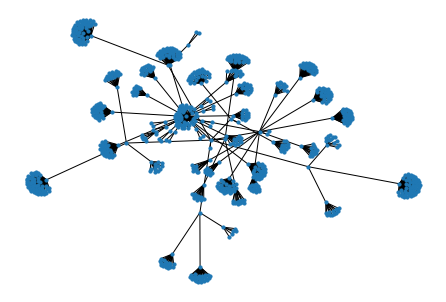

In [108]:
G = makeGraph(record)
nx.draw(G, node_size = 10)
#plt.savefig("decision_tree.png")

In [442]:
print(len(G.nodes))
print(len(G.edges))

807
807


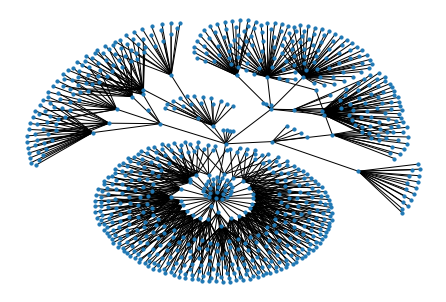

In [443]:
nx.draw_kamada_kawai(G, node_size = 10)
#plt.savefig("decision_tree.png")

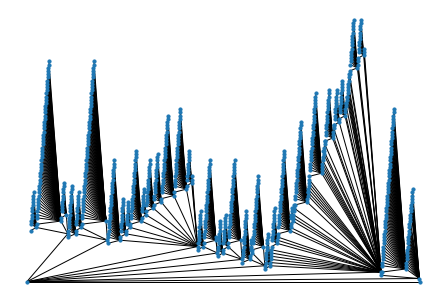

In [112]:
nx.draw_planar(G, node_size = 10)
plt.savefig("decision_tree3.png")

# Predictions 

In [102]:
# getting some personal details
def getInfo(i):
    
    print("Age =", data[i][varInd['AGE']])
    
    sex = data[i][varInd['SEX']]
    if sex=='1':
        out = "male"
    elif sex=='2':
        out = 'female'
    else:
        out = 'error'
    print("Sex =", out)
    
    marst = data[i][varInd['MARST']]
    if marst=='1' or '2' or '3':
        out = 'married'
    elif marst=='4' or '5' or '7':
        out = 'divorced or widowed'
    elif marst=='6':
        out = 'single'
    else:
        out = 'error'
    print("Marital status =", out)
    
    emp1 = data[i][varInd['EMPSTAT']]
    if emp1 in ['1', '10', '12']:
        out = 'employed'
    elif emp1 in ['21', '22']:
        out = 'unemployed'
    elif emp1 in ['0', '32', '34', '36']:
        out = 'not in labor force'
    else:
        out = 'error'
    print("Employment status year 1 =", out)
        
    emp2 = data[i][varInd['EMPSTAT2']]
    if emp2 in ['1', '10', '12']:
        out = 'employed'
    elif emp2 in ['21', '22']:
        out = 'unemployed'
    elif emp2 in ['0', '32', '34', '36']:
        out = 'not in labor force'
    else:
        out = 'error'
    print("Employment status year 2 =", out)
    
    #print("Occupation =", data[i][varInd['OCC']])

In [103]:
# takes the index of an observation in the data, 
# the record of a decision tree, 
# and the index of a goal variable to predict 
# (which has to be the same as what the decision tree record is predicting)
def tellFuture(index, record, goalNum):
    goalName = data[0][goalNum]
    getInfo(index)
    print()
    pred = getPred(index, record, goalNum)
    print("Predicting:", goalName)
    print("Prediction:", goalLevels[goalName][pred])
    print("Truth:", data[index][goalNum])

In [105]:
tellFuture(105, record, goal)

Age = 54
Sex = male
Marital status = married
Employment status year 1 = employed
Employment status year 2 = employed

Predicting: EMPSTAT2
Prediction: ['1', '10', '12']
Truth: 10
